In [1]:
# Let's the notebook see custom code
import sys
sys.path.insert(1, '/users/wx21978/projects/pion-phys/pi0-analysis/analysis/')
# Lets a module be reloaded without restarting the whole kernel
from importlib import reload
# Basic imports
import os
import copy
import numpy as np
import tensorflow as tf
import tensorflow_gnn as tfgnn
from tensorflow_gnn.models import gat_v2
from tensorflow import keras
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
import time
import timeit
# Custom code
from python.gnn import DataPreparation, Models, bdt_classifier, Layers
from python.analysis import EventSelection, Plots, vector, PairSelection, Master, PFOSelection, cross_section, CutOptimization
from python.analysis import SelectionEvaluation as seval
import apps.cex_analysis_input as cai

2024-08-02 12:08:52.091490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## ProtoDUNE event classification with Graph Neural Networks (GNNs)
This notebook serves as a overview of the mechanism developed for creating, training, sav-/load-ing, and evaluation of a GNN.

Most of the behind the scene is hidden within 3 python modules, found under `python/gnn/`.
 - `DataPreparation` handles formating the input data - moving from ntuples to tensorflow graphs, and the saving and loading thereof
 - `Layers` contains layers that we can use to construct our GNN.
 - `Models` handles construction of models from Layers, training, and basic output plots.

### Data generation
This section concerns data generation. It should only need be run when you make changes to the properties in the graphs themselves.

Current graphs can be found (on sc01) at `/storage/wx21978/gnn`.

First, the events are loaded. This applies a basic set of beam selection cuts.

Then, we load a pre-trained BDT to use these as inputs for the nodes of the graphs.

The properties to use in the graph are listed, refering to sets of dictionaries defining the properties we can use.
These can be seen at the top of the `DataPreparation` module.
These are used to define the graph generation.

The graphs are finally generated by calling `DataPreparation.generate_training_data` on teh dictionary of parameters constructed by the above step.

In [ ]:
# Load the events (ntuples) from which to make the graphs
conf_file = "/users/wx21978/projects/pion-phys/analyses/3GeV_both/config_3GeV_MC_data.json"
conf_args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(conf_file))
args_c = cai.args_to_dict(conf_args)
file_dict = conf_args.ntuple_files["mc"][1]
evts = Master.Data(file_dict["file"], nTuple_type="PDSPAnalyser", target_momentum=file_dict["pmom"])
set_1_evts_selected = cai.BeamPionSelection(evts, args_c, True)

In [ ]:
# Setup the BDT as in input for the node information
'''
bdt_props = [
    "track", "length", "nhits",
    "dEdx_med", "dEdx_sum", "dEdx_var", "dEdx_start10%", "dEdx_end25%",
    "chi2_pion_reduced", "chi2_proton_reduced", "chi2_muon_reduced"]
bdt_truths = ["pion", "photon", "proton"]

bdt_holder = bdt_classifier.BDTPropertyGenerator(bdt_props, bdt_truths)

bdt_holder.train(evts)

bdt_holder.save("/path/to/bdt/bdt_pfo.dll")
'''
loaded_bdt = bdt_classifier.loadBDT("/storage/wx21978/gnn/bdt_pfo.dll")

bdt_classify_definitions = DataPreparation.default_kinematic_definitions
def get_bdt_output(index, bdt):
    def func(events):
        n_pfos = ak.count(evts.recoParticles.number, axis=1)
        predictions = bdt.predict_proba(events)[:, index]
        return ak.unflatten(predictions, n_pfos)
    return func

bdt_classify_definitions["bdt_pion"] = get_bdt_output(0, loaded_bdt)
bdt_classify_definitions["bdt_photon"] = get_bdt_output(1, loaded_bdt)
bdt_classify_definitions["bdt_proton"] = get_bdt_output(2, loaded_bdt)
bdt_classify_definitions["bdt_other"] = get_bdt_output(3, loaded_bdt)

In [ ]:
# Setup the information contained in the graph
classifications = [ # These are the regions to use. Refer to DataPreparation.default_classification_definitions
    "absorption", "charge_exchange",
    "single_pion_production", "multi_pion_production"]
kinematic_props = [ # Information on each PFO
    "bdt_pion", "bdt_photon", "bdt_proton", "bdt_other", # From BDT
    "track", "n_hits"] # From ntuples (DataPreparation.default_kinematic_definitions)
# Information between lines, see DataPreparation.default_geometric_definitions
geom_props = ["separation_shower_shower", "closest_approach_shower_shower", "impact_parameter_shower"]
# Information on beam connections, see DataPreparation.default_beam_definitions
beam_props = ["impact", "separation"]

folder_path = "/path/to/store/record/"

data_bdt_params = DataPreparation.create_parameter_dictionary(
    folder_path,
    evts,
    classifications, kinematic_props, geom_props, beam_connections=beam_props,
    # Use the bdt_classify_definitions defined in above cell
    kinematic_definitions=bdt_classify_definitions, norm_kinematics=True,
    geometric_definitions=DataPreparation.default_geometric_definitions,
    beam_definitions=DataPreparation.default_beam_definitions,
    truth_info=True, # Include truth information (must be false when making data graphs)
    data_type="reco") # Reconstruction tier (no truth information), can be "data", "bt", or "mc"

In [ ]:
# N.B. takes 15-20 minutes
DataPreparation.generate_training_data(data_bdt_params)

### Construction
Construction is handled by generating a list of Layers.
Graph information flows linearly through the list of Layers, unless the Layer is passed with an strign argument, which identifies it as an output layer (referenced by the passed string).
In this case, the state before the output layer continues through the network, and the result from the output layer can be sent to the output by passing a list of strings, corresponding to the names of the output layers.

Additionaly, `LoopConstructor`s may be used to group together (and loop) sets of Layers.
This can simply be used to generate repeating layers, or could be used to generate a more complex ouptut, which requires many layers which should not be passed further into the network.

Details of each Layer (kwargs) should be looked up the `Layers`.
A parameters dictionary stores any model-wide default parameters to use. This will be passed into each layer of the model, but can be overwritten if the Layer initialisation includes reference to one of these properties.
The Layers should ignore any elements in the parameters dictionary which is unrelated to their layer.

The model itself is only constrcted after the training is setup, since it uses file path of the hyper parameters to ensure the model is looking for graphs of the correct data.

The main benefit of this method, is that it can save the full model configuration as a text file.
This file can then be loaded (and even adjusted) to reload the model (with small tweaks).
This new model can then have the weights which are save from the end of training imposed onto it.
This works around and issue that was observed with trying to save GNNs which can output ragged tensor type data (i.e. per PFO losses).

In [2]:
## Basic model storage info

# "data" for reco data only
# "bt" for reco PFOs, but truth information
# "mc" for truth PFOs and truth information
data_type = "data"
model_name = "Model_data_PNA_1"
model_type="PNA"

model_path = "/path/to/storage/" + model_name
print(f"Model saved to:\n{model_path}")

path_params = DataPreparation.create_filepath_dictionary("/path/to/training/record/folder/")

Model saved to:
/users/wx21978/projects/pion-phys/analyses/3GeV_MC_only/gnn_data/models/Model_data_PNA_0


In [4]:
# Default params for all layers
model_params = {
    "node_dim": 32,
    "beam_node_dim": 64,
    "edge_dim": 8,
    "beam_edge_dim": 8,
    # Dimensions for PNA message passing
    "message_dim": 16,
    "beam_message_dim": 32,
    # Dimensions for GATv2 message passing.
    # "message_heads": 4,
    # "message_channels": 8,
    # "beam_message_heads": 8,
    # "beam_message_channels": 8,
    # Other hyperparameters.
    "regularisation": 8e-5,
    "dropout_rate": 0.5,
    "activation": "leaky_relu"
}

# Core message passing step of the netowrk (goes into a LoopContructor)
model_message_passing = [
    Layers.PFOUpdate(message_type="PNA"),
    Layers.NeighbourUpdate(final_step=False),
    Layers.BeamCollection(message_type="PNA"),
    Layers.BeamConnectionUpdate(final_step=False)
]

# Core of the model, controling the flow, and update of information
model_constructor = [
    Layers.Setup(),
    Models.create_normaliser_from_data(path_params),
    Layers.InitialState(pfo_hidden=(128, 1),
                        dropout_rate=0.3,# activation="leaky_relu",
                        neighbours_hidden=None,
                        beam_connections_hidden=None),
    # Layer is an output if given positional argument
    Layers.ReadoutClassifyNode("pion_id", which_nodes="pfo"),
    Layers.ReadoutClassifyNode("photon_id", which_nodes="pfo"),
    Layers.BeamCollection(message_type="PNA", next_state="concat"),
    # Loop constructor creates a sub loop
    Layers.LoopConstructor(model_message_passing,
                           loops=2),
    Layers.ReadoutClassifyEdge("pi0_id", which_edges="neighbours"),
    Layers.ReadoutNode(which_nodes="beam"),
    Layers.Dense(depth=64, n_layers=1),
    Layers.Dense("pion_count", depth=1, name="pion_count", activation="relu", regularisation=None),
    Layers.Dense("pi0_count", depth=1, name="pi0_count", activation="relu", regularisation=None),
    Layers.Dense(depth=64, n_layers=2, dropout_rate=0.3),
    Layers.Dense("reco_classification", depth=4, name="reco_classifier"),
    Layers.Dense("classifier", depth=4, activation="linear", name="classifier")
]

# References to labelled output Layers, controls the ordering of the outputs.
model_outputs = ["classifier",
                 "pion_count", "pi0_count",
                 "pion_id", "photon_id", "pi0_id",
                 "reco_classification"]

### Training

Each output of the model requires a loss to be trained against.
These are specified in the first cell, along with metrics to let us track the performance of each loss.
We also must specify the truth that it is aiming for, and some callbacks to assist training.

A dictionary of hyper parameters is then generated to store information about the training process.
This includes:
 - Paths/losses/metric/callbacks all previously defined
 - Basic learning rate (overwritten by the lr_scheduler callback)
 - Maximum number of epochs to train for (should be stopped by the early stopping callbakc before this)
 - Number of batches per epoch (654 calculated as the number of training events divided by batch size of 32)
 - The extra losses the model uses. See notes below.
 - Loss weights, relative importance of _all_ losses (see notes).
 - Path to the data.
 - Batch size.
 - How manyof the next events from which to randomly sample each batch as shuffling.

After this is constructed, data and model are easily generated from the hyper params, and the model construction defined above.

#### Extra losses

The main classification loss is assumed to be always used, and set as the first model output.
Any additional losses must be specified to the hyper parameters.
These are given as a list of strings under the kwarg `extra_losses`,.
These strings should reference and option in the `DataPreparation._make_decode_func` function.
Any additional losses to be added must also be defined in thie function.

The losses are then given a relative scaling (how big a graph update it causes) passed as a list of numbers in the `loss_weights` kwarg.
Note that this list includes the base classifier (i.e. should have the same length as `model_outputs`), but the `extra_losses` list doesn't include the base, and this should have one# fewer element.

#### Initial experiementation
I am curious as to the performance of the GNN in terms model outputs if the `reco_class` is considered the more importance calssificaiton than the main classifier. You should be able to achieve this be editing the loss weights.

Then, another thing of interest would be to not use logits in the final output. this will requrie a small tweak to the model construction as well.
Logits are the raw GNN outputs, but it can be nicer to instead normalise the outputs as a unit normalised vector, with values betwen [0, 1].

In [3]:
"""Multiple loss parameters"""
# Need one loss per model ouptut.
# See https://www.tensorflow.org/api_docs/python/tf/keras/losses for an overview of losses
loss = [tf.keras.losses.CategoricalFocalCrossentropy(gamma=3., alpha = [0.21, 0.48, 0.21, 0.10], from_logits=True),
        # tf.keras.losses.CategoricalFocalCrossentropy(gamma=3., alpha = [0.27, 0.48, 0.16, 0.09], from_logits=True),
        # tf.keras.losses.CategoricalFocalCrossentropy(alpha = [0.275, 0.5, 0.2625, 0.1875], from_logits=True),
        tf.keras.losses.MeanSquaredError(name="mse_pions"),
        tf.keras.losses.MeanSquaredError(name="mse_pi0s"),
        tf.keras.losses.BinaryFocalCrossentropy(name="pion_pfo_binary_focal_ce", from_logits=True),
        tf.keras.losses.BinaryFocalCrossentropy(name="photon_pfo_binary_focal_ce", from_logits=True),
        tf.keras.losses.BinaryFocalCrossentropy(name="pi0_edge_binary_focal_ce", from_logits=True),
        tf.keras.losses.CategoricalFocalCrossentropy(from_logits=True)]


# See https://www.tensorflow.org/api_docs/python/tf/keras/metrics for an overview of metrics
class_metrics = [tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy_class"),
                 tf.keras.metrics.AUC(num_thresholds=100, from_logits=True, name="auc_class"),
                 tf.keras.metrics.F1Score(name="f1_score_class"),
                 tf.keras.metrics.F1Score(average="weighted", name="f1_score_weighted_class"),
                 tf.keras.metrics.Precision(top_k=1, name="purity_class"),
                 tf.keras.metrics.Recall(top_k=1, name="efficiency_class")]

reco_class_metrics = [tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy_reco_class"),
                      tf.keras.metrics.AUC(num_thresholds=100, from_logits=True, name="auc_reco_class"),
                      tf.keras.metrics.F1Score(name="f1_score_reco_class"),
                      tf.keras.metrics.F1Score(average="weighted", name="f1_score_weighted_reco_class"),
                      tf.keras.metrics.Precision(top_k=1, name="purity_reco_class"),
                      tf.keras.metrics.Recall(top_k=1, name="efficiency_reco_class")]

regr_metrics_pion = [tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error_pion"),
                     tf.keras.metrics.R2Score(name="r^2_score_pion")]
regr_metrics_pi0 = [tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error_pi0"),
                    tf.keras.metrics.R2Score(name="r^2_score_pi0")]

# Generates a new list of Accruacy, Precision (purity) and Recal (efficiency) metrics
def get_class_metric_list(id, base_name="pi0_id", from_logits=True):
     thresh = 0. if from_logits else 0.5
     return [tf.keras.metrics.BinaryAccuracy(threshold=thresh, name=f"binary_accuracy_{base_name}_{id}"),
                     tf.keras.metrics.Precision(thresholds=thresh, name=f"purity_{base_name}_{id}"),
                     tf.keras.metrics.Recall(thresholds=thresh, name=f"efficiency_{base_name}_{id}")]

metrics = [
     class_metrics,
     regr_metrics_pion, regr_metrics_pi0,
     get_class_metric_list("pion", "pfo_id"), get_class_metric_list("photon", "pfo_id"),
     get_class_metric_list("direct"),
     reco_class_metrics]

# Manually specifies the learning rate (size of updates) as a function of the number of training steps performed
def lr_scheduling(epoch):
    if epoch < 8:
        return 1e-3
    if epoch > 20:
        return 5e-5
    # if (epoch > 148) and (epoch < 200):
    #     return 1e-3
    return 1e-4

# Callbacks can adjust training parameters during the training process.
# In this case, this is to stop when the model stopping improving,
#   and adjusting the larning rate as a function of epoch
callbacks=[
     tf.keras.callbacks.EarlyStopping(
          min_delta=1e-4, patience=24, restore_best_weights=True, start_from_epoch=16, verbose=1,
          monitor="val_loss"),
     tf.keras.callbacks.LearningRateScheduler(lr_scheduling)]

In [5]:
"""Data, multiple loss version"""
hyper_params = Models.generate_hyper_params(
    model_path,
    loss,
    metrics,
    callbacks,#[0],
    1e-4,
    2048,
    654,
    extra_losses = ["bt_pions", "bt_pi0s", "pion", "photon", "true_pi0", "reco_class"],
    loss_weights=[1,    5e-3  ,    1e-3  ,  1e-2 ,   1e-4  ,     1e-4  ,     1e-6    ],
    # extra_losses = ["pion", "photon", "true_pi0", "reco_class"],
    # loss_weights=[1, 1e-2 ,   1e-3  ,     1e-3  ,     1e-5    ],
    # class_weights={0: 1.2, 1: 3., 2:1., 3:1.},
    data_folder=path_params["folder_path"],
    training_batch=32,
    training_shuffle=1024)

In [6]:
train_ds_batched, val_ds_batched = Models.load_data_from_hyper_params(hyper_params)
model = Models.construct_model(hyper_params,
                               model_constructor,
                               model_params,
                               model_outputs,
                               model_type=model_type)
'''
def compile_and_train(
        model,
        hyper_params,
        batched_train,
        batched_val,
        print_summary=True,
        partial_train=False):
    """
Compiles and trains a TensorFlow Keras model based on the provided
hyper parameters and datasets.

Parameters
----------
model : tf.keras.Model
    The TensorFlow Keras model to be compiled and trained.
hyper_params : dict
    Dictionary containing hyper-parameters for compiling and training
    the model, as generated by `Models.generate_hyper_params`.
batched_train : tf.data.Dataset
    Batched training dataset.
batched_val : tf.data.Dataset
    Batched validation dataset.
print_summary : bool, optional
    Whether to print the model summary. Default is True.
partial_train : bool, optional
    If True, save the weights as "_partial" at the end of training.
    This can be used as a training checkpoint to load later.  Intent is
    to allow changing loss weightings partly through the process.
    Default is False.

Returns
-------
history : tf.keras.callbacks.History
    A record of training loss values and metrics values at successive
    epochs, as well as validation loss values and validation metrics
    values.
"""
    model.compile(
        tf.keras.optimizers.Adam(learning_rate=hyper_params["learning_rate"]),
        loss=hyper_params["loss"],
        loss_weights = hyper_params["loss_weights"],
        metrics=hyper_params["metrics"])
    if print_summary:
        model.summary()
    history = model.fit(batched_train,
                        class_weight=hyper_params["class_weights"],
                        steps_per_epoch=hyper_params["steps_per_epoch"],
                        epochs=hyper_params["epochs"],
                        callbacks=hyper_params["callbacks"],
                        validation_data=batched_val)
    # This save only saves a model which can do inference, it doesn't
    #   have full (i.e. fitting) functionality
    # model.export(hyper_params["model_path"])
    # Saving not currently working - need to use strings as dftype formatting?
    if not partial_train:
        model.save_weights(hyper_params["weights_path"])
        model.save(hyper_params["model_path"], save_format="tf", overwrite=False)
    else:
        partial_weights_path = hyper_params["weights_path"] + "_partial"
        model.save_weights(partial_weights_path)
    with open(hyper_params["history_path"], "wb") as f:
        pickle.dump(history.history, f)
    return history
'''

### Training step
This is where the model actually trains.
For implementing an adversarial training, a new function, similar to `Models.compile_and_train`, will need to be created.

This will use the custom adversial training steps, and likely take in two models, one as the GNn, one as the adversary.

In [7]:
history = Models.compile_and_train(model, hyper_params, train_ds_batched, val_ds_batched)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [()]                         0         []                            
                                                                                                  
 input.merge_batch_to_compo  ()                           0         ['input_1[0][0]']             
 nents (InstanceMethod)                                                                           
                                                                                                  
 map_features (MapFeatures)  ()                           0         ['input.merge_batch_to_compone
                                                                    nts[0][0]']                   
                                                                                              

/software/wx21978/miniconda/envs/pi0-phys-ak/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/software/wx21978/miniconda/envs/pi0-phys-ak/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/software/wx21978/miniconda/envs/pi0-phys-ak/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this StructuredValue will requ

INFO:tensorflow:Assets written to: /users/wx21978/projects/pion-phys/analyses/3GeV_MC_only/gnn_data/models/Model_data_PNA_0/model.tf/assets


INFO:tensorflow:Assets written to: /users/wx21978/projects/pion-phys/analyses/3GeV_MC_only/gnn_data/models/Model_data_PNA_0/model.tf/assets


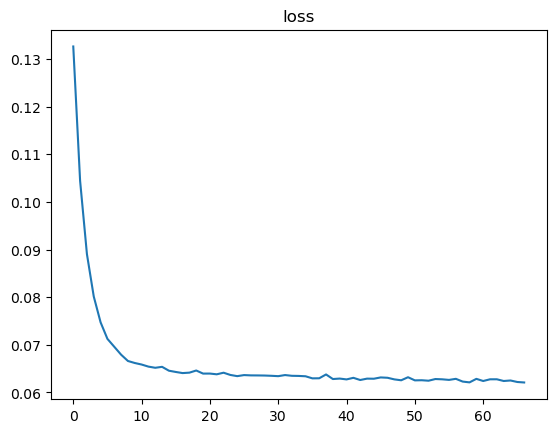

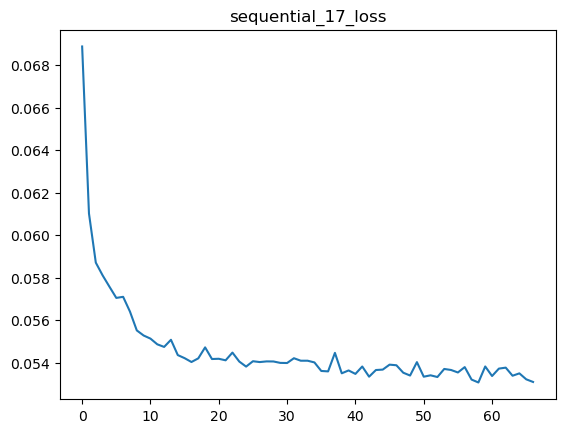

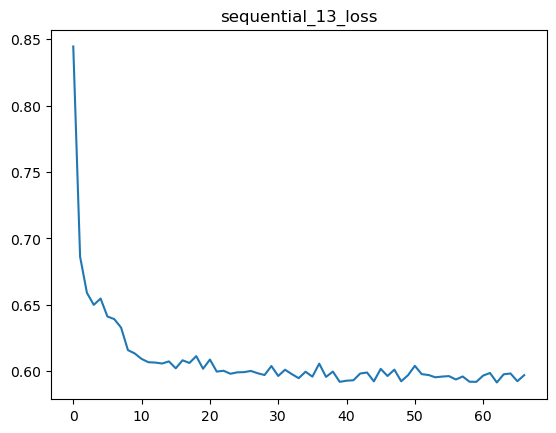

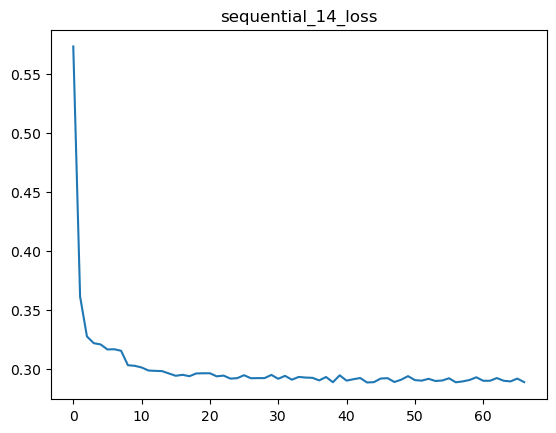

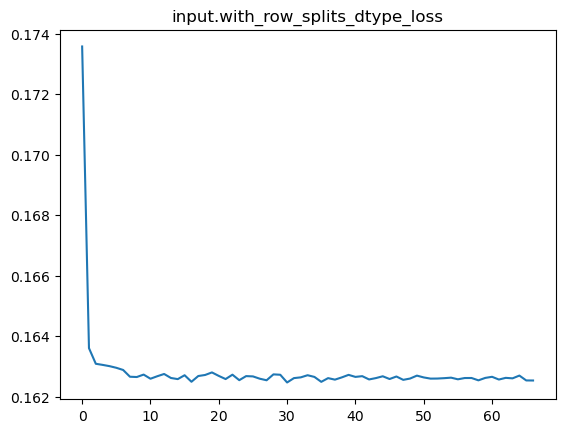

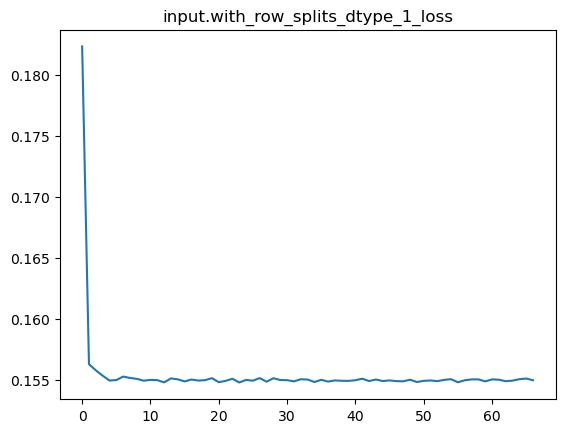

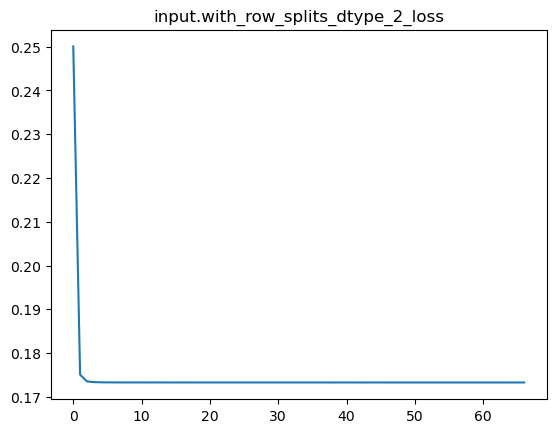

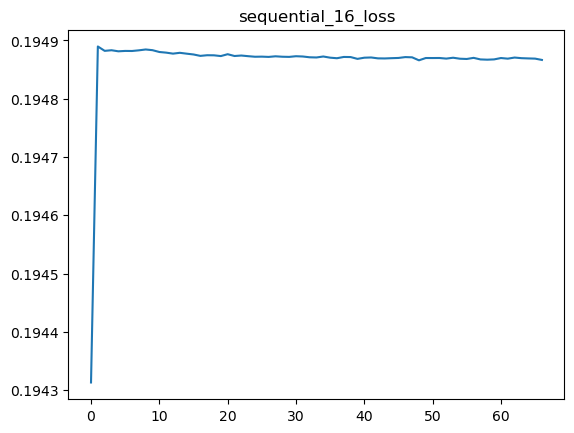

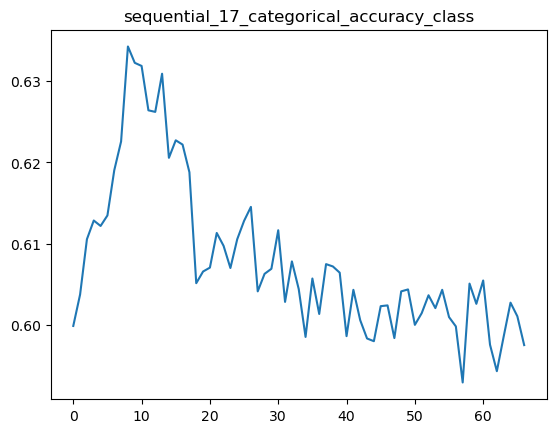

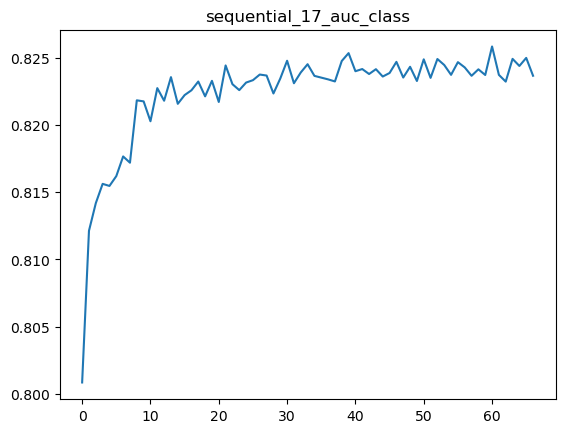

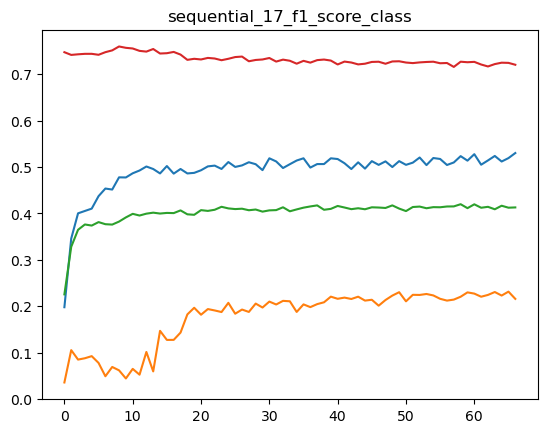

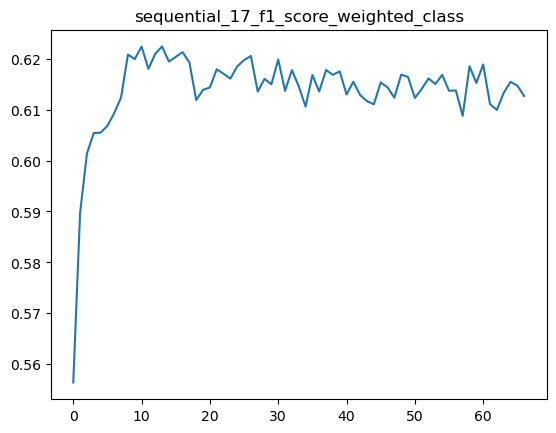

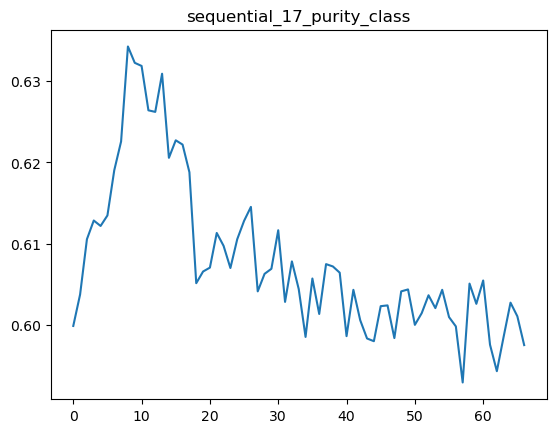

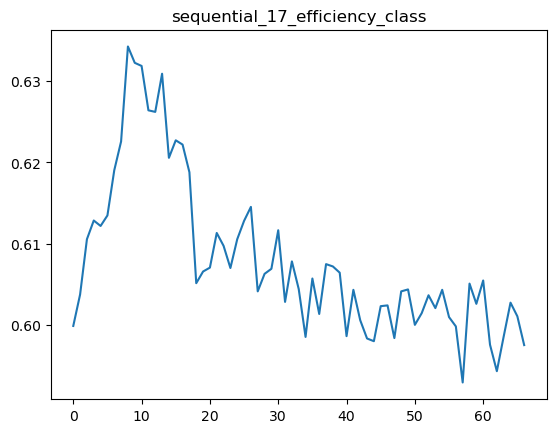

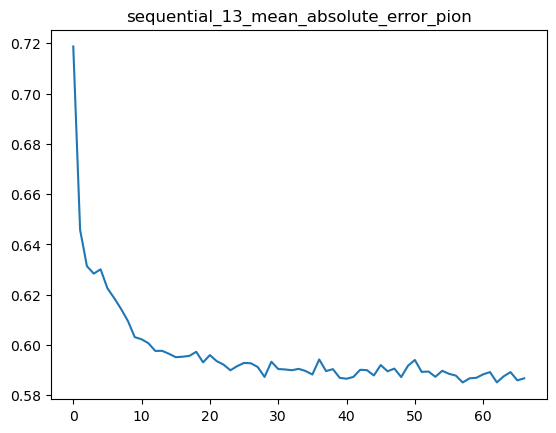

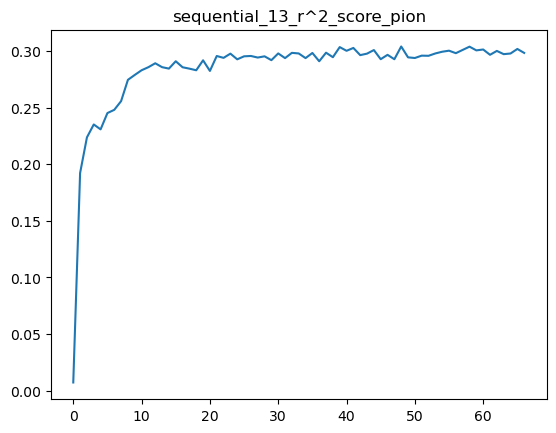

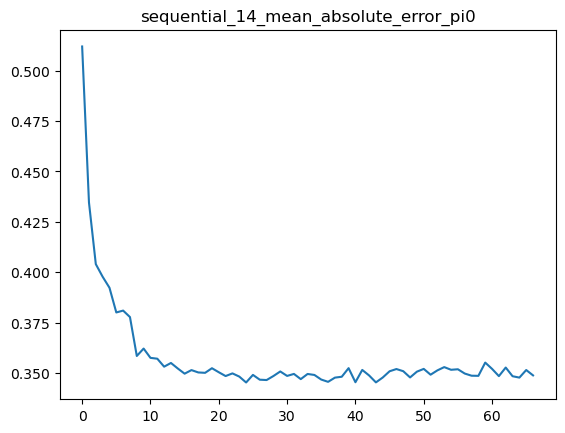

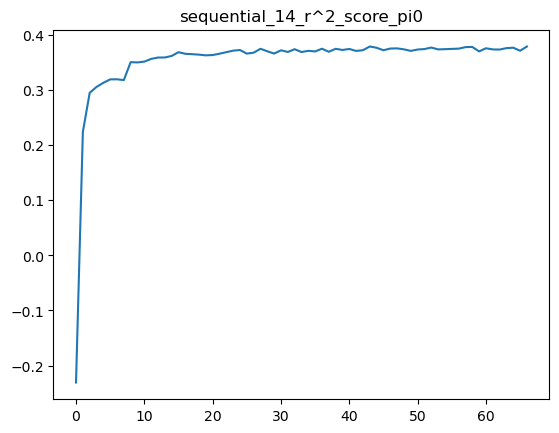

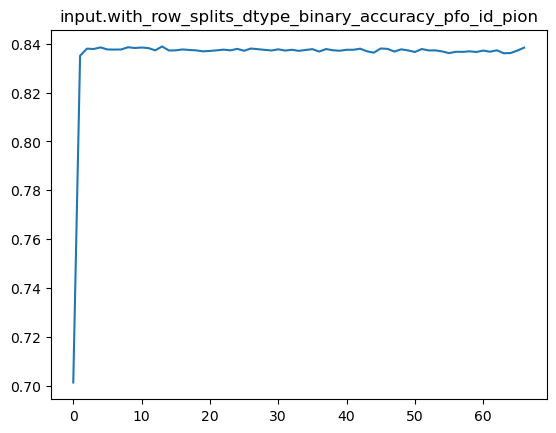

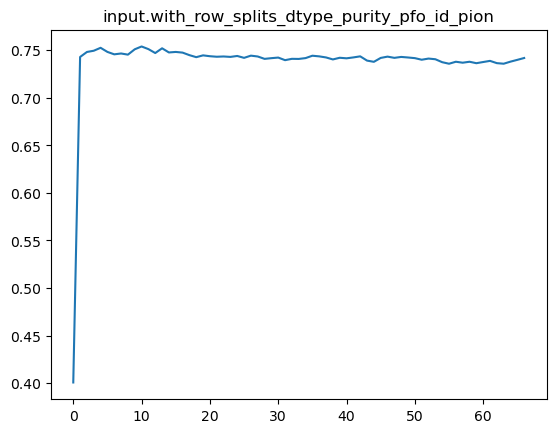

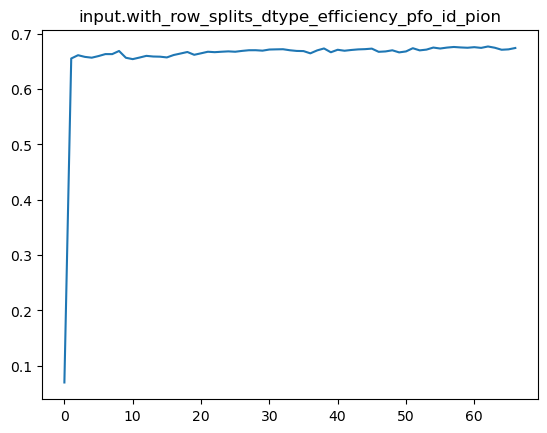

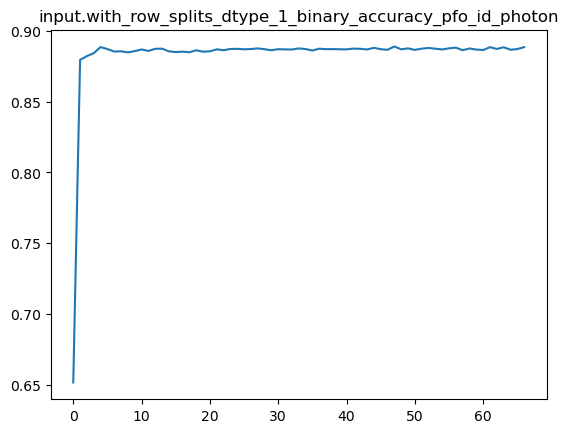

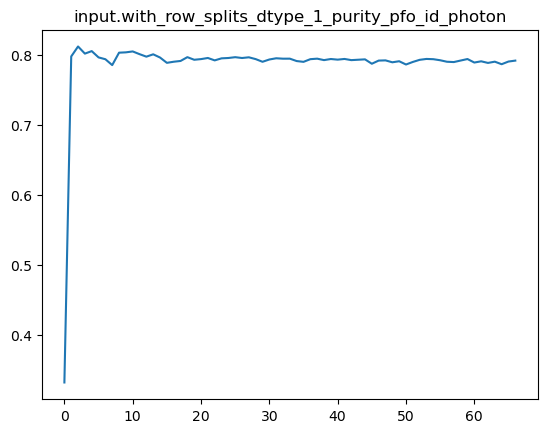

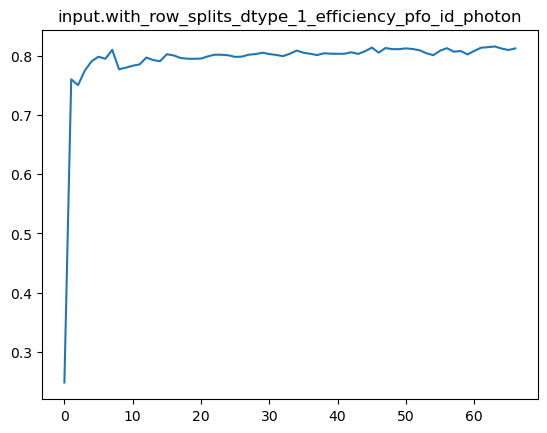

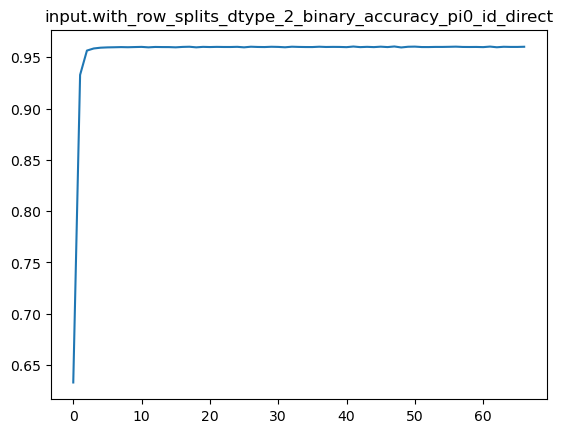

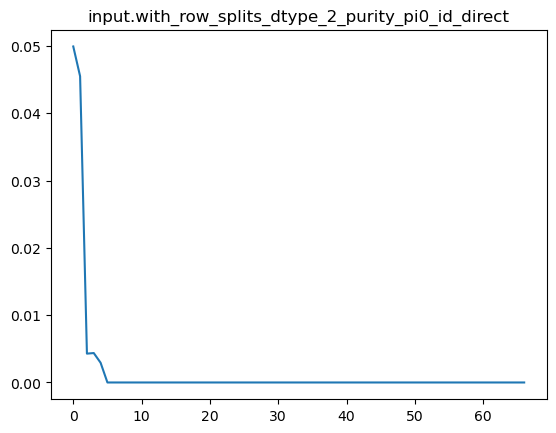

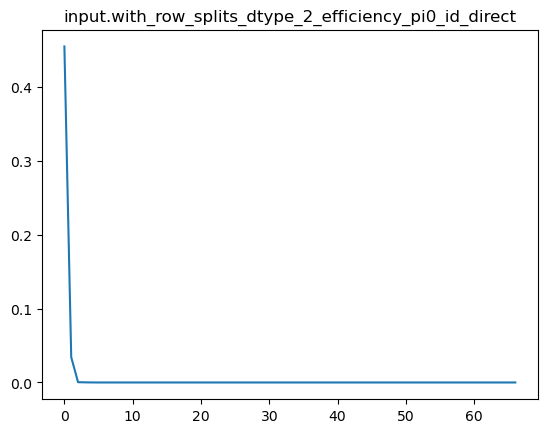

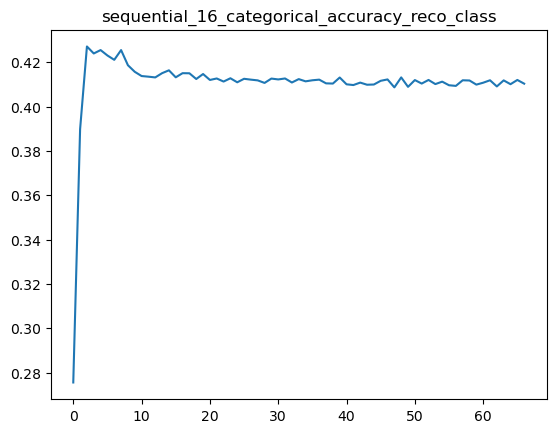

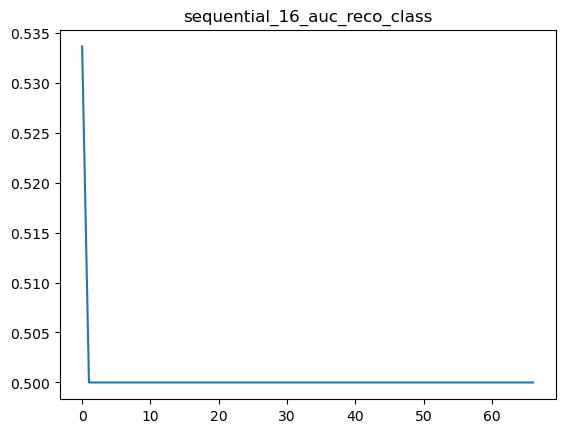

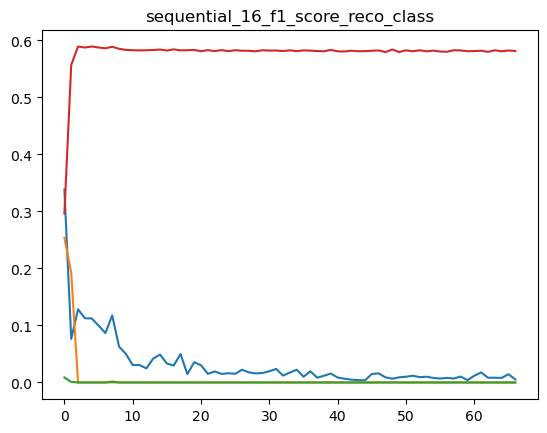

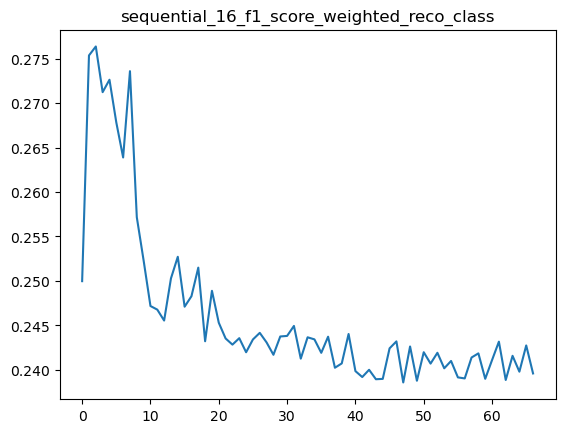

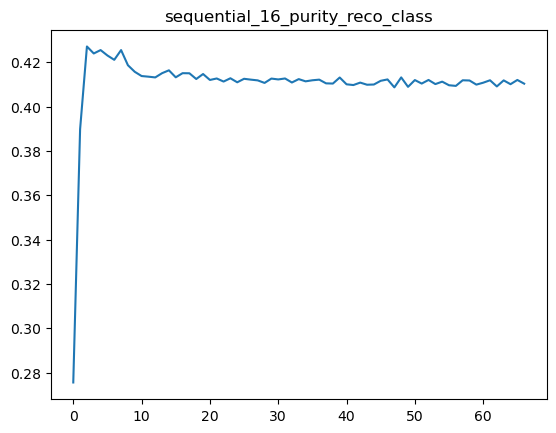

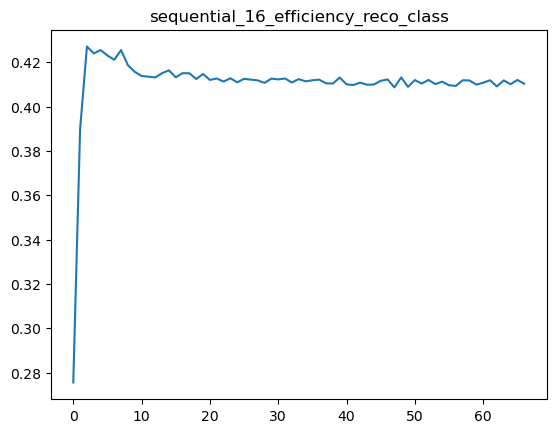

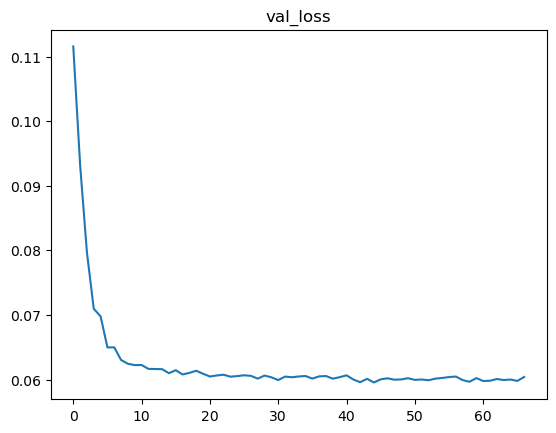

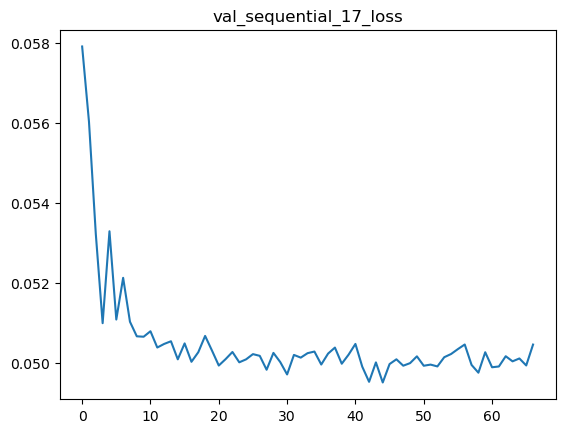

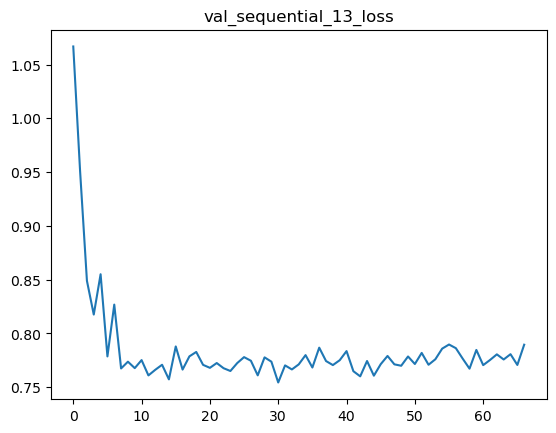

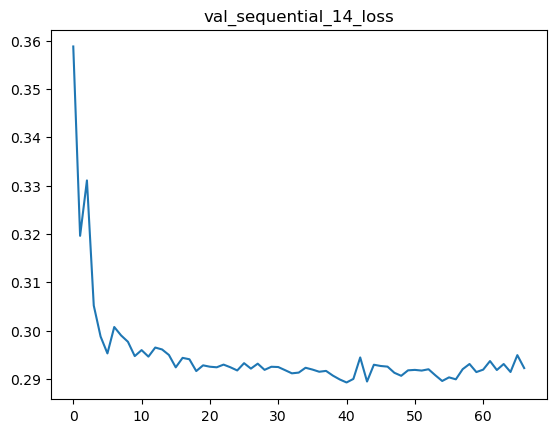

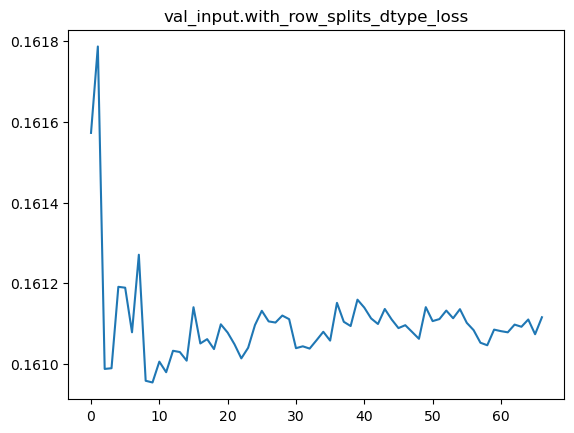

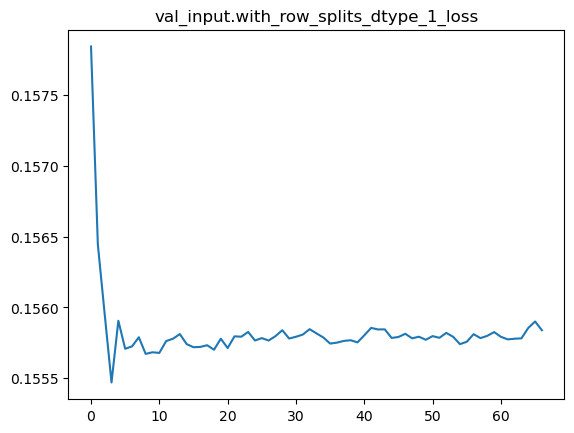

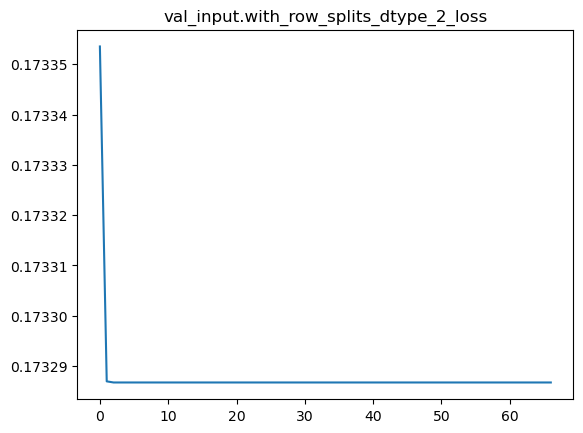

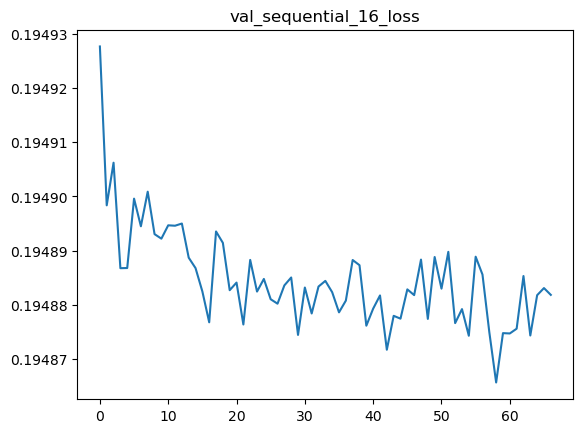

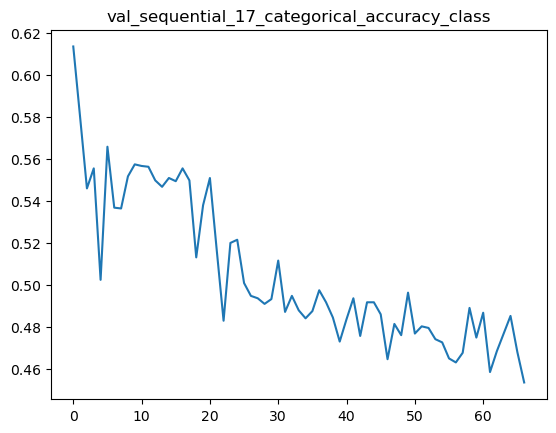

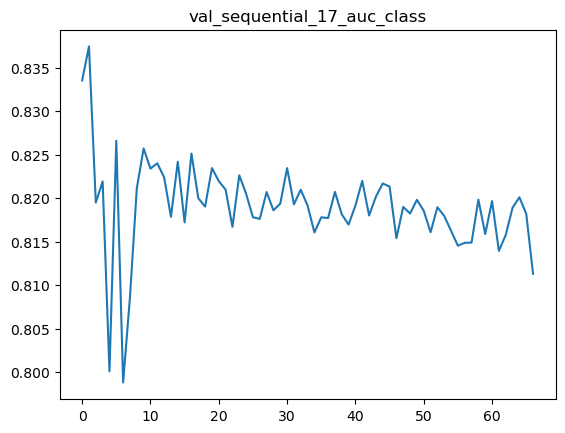

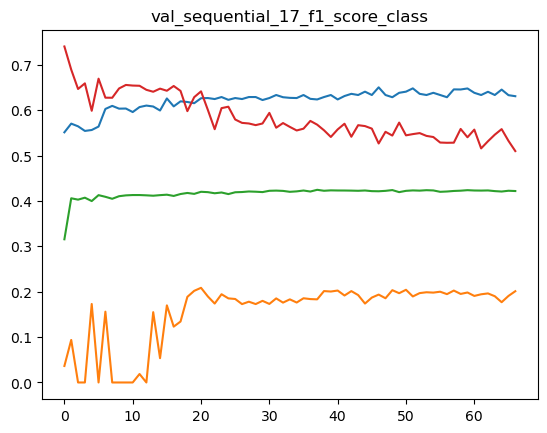

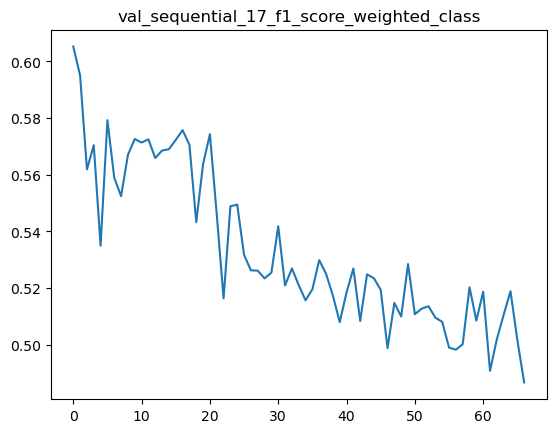

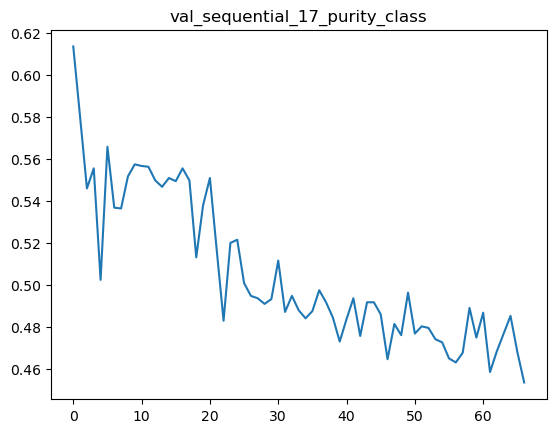

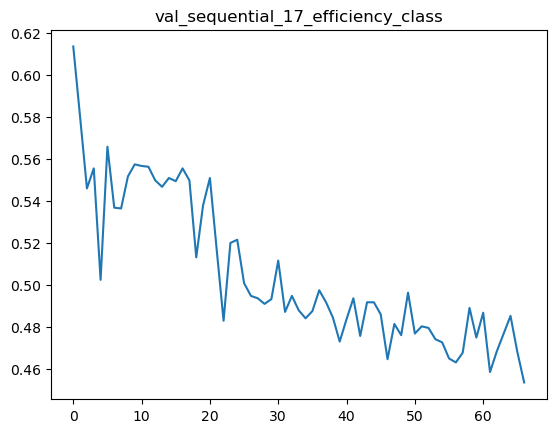

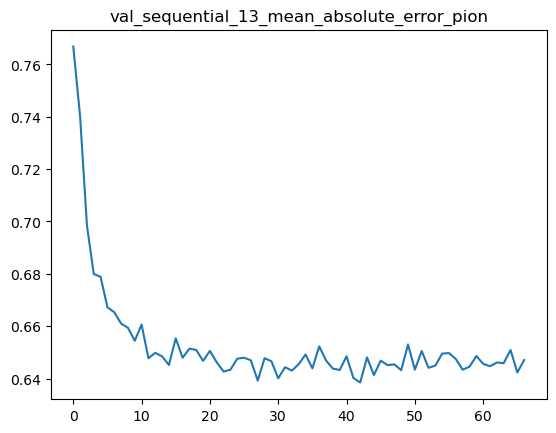

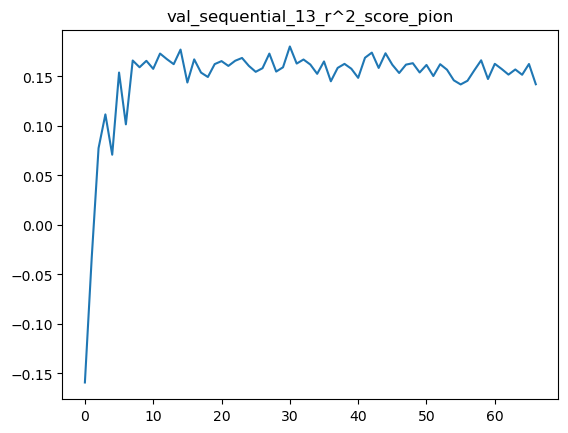

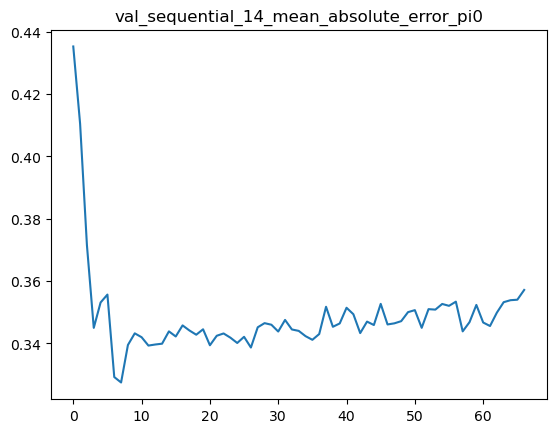

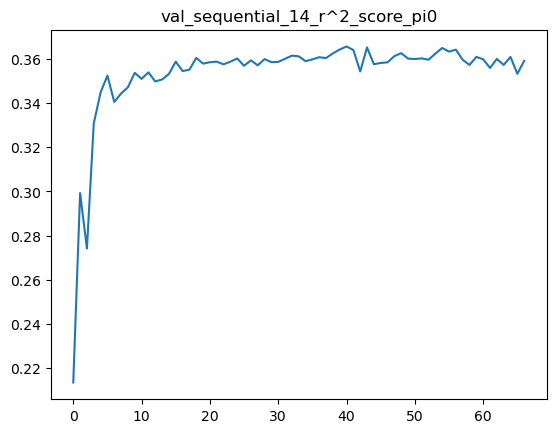

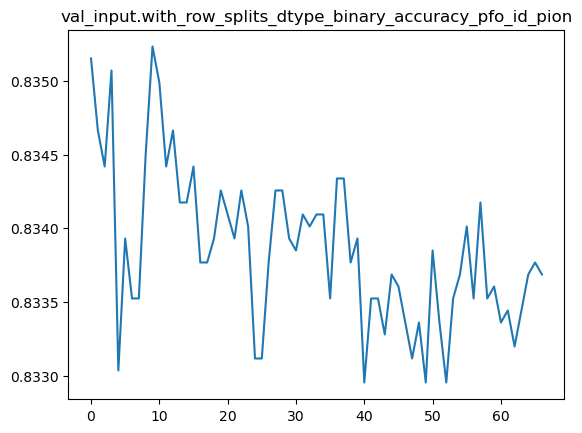

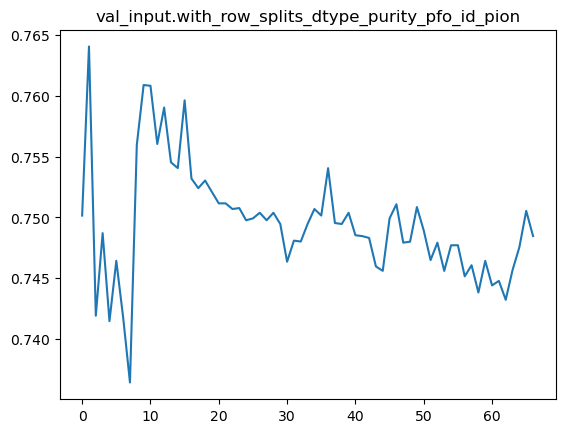

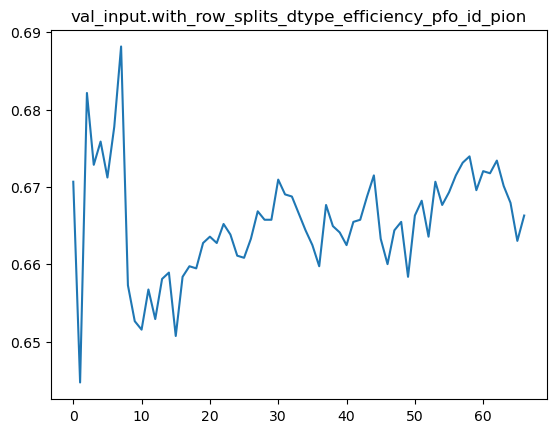

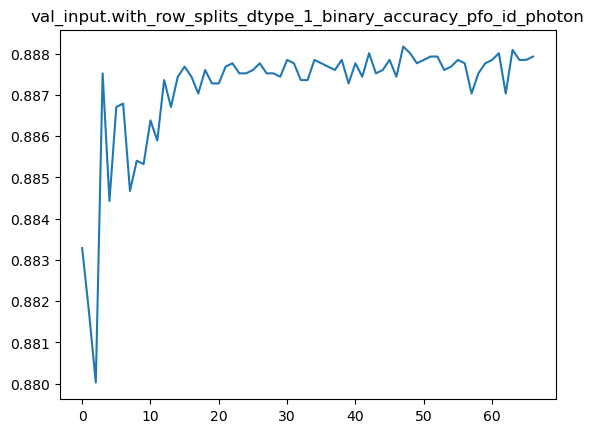

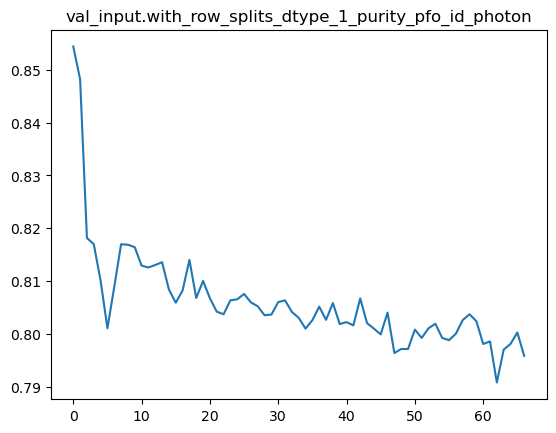

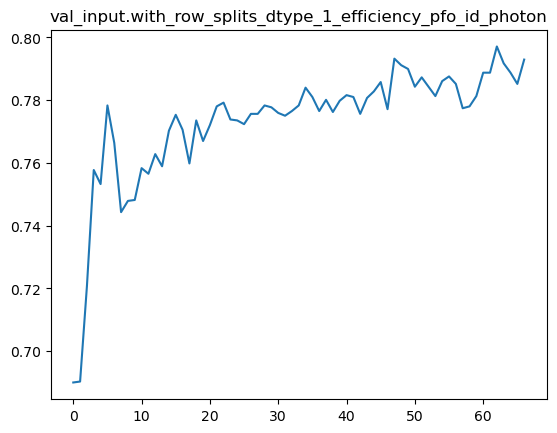

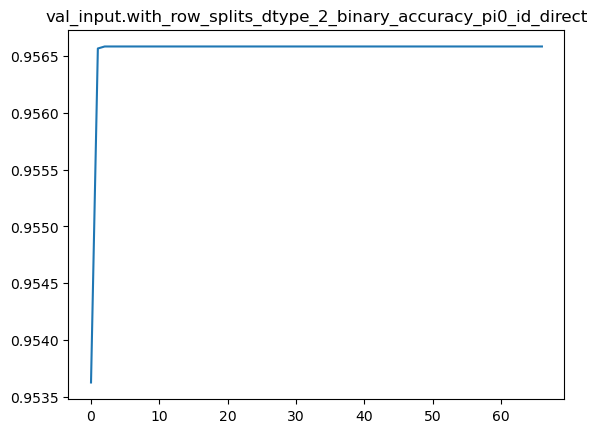

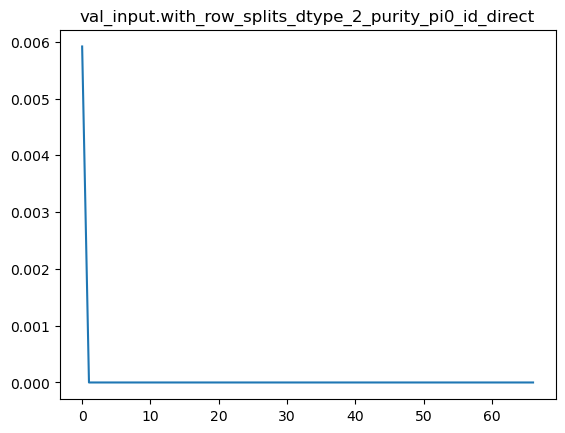

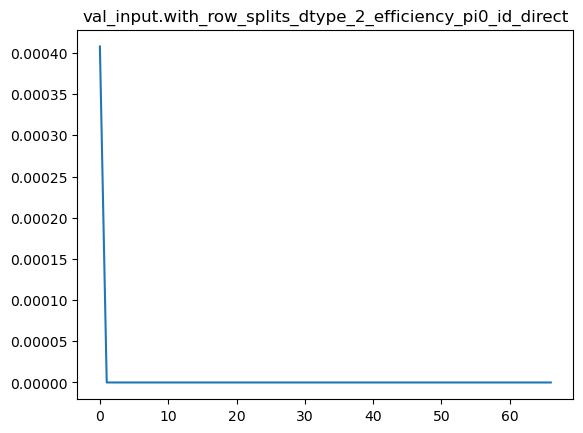

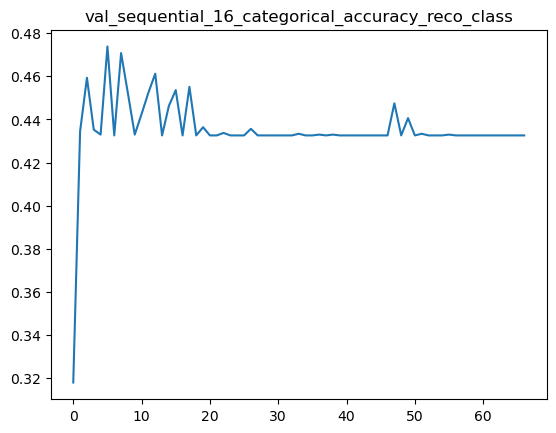

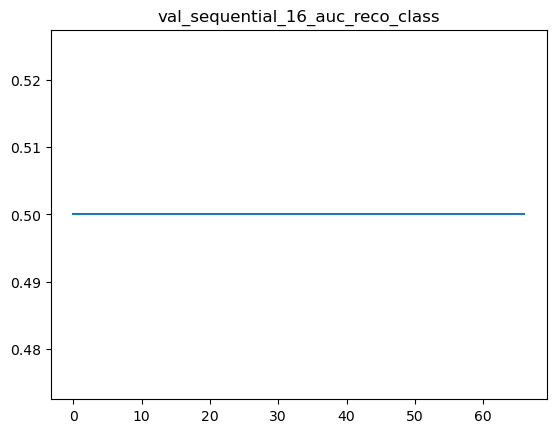

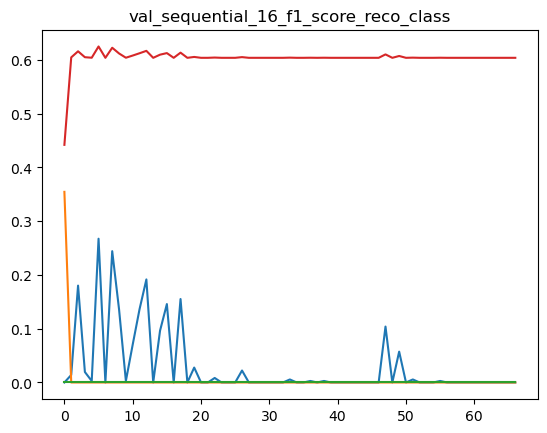

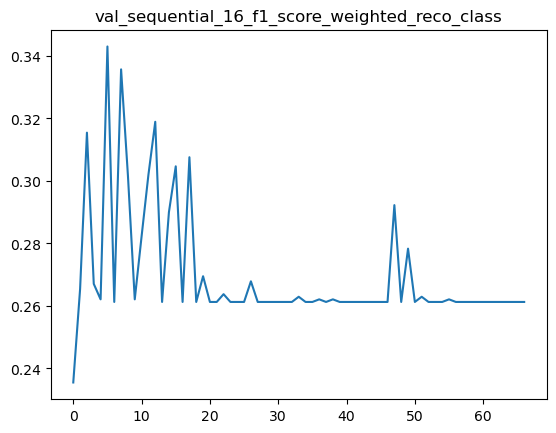

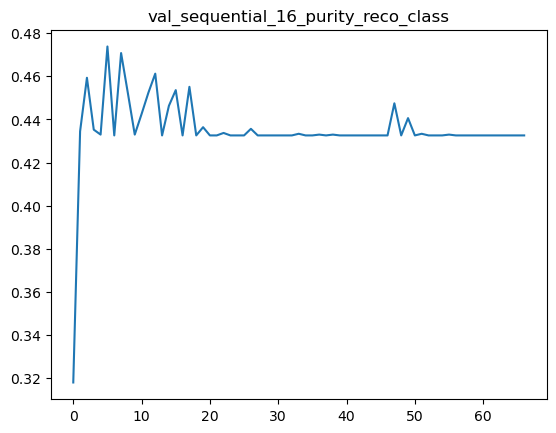

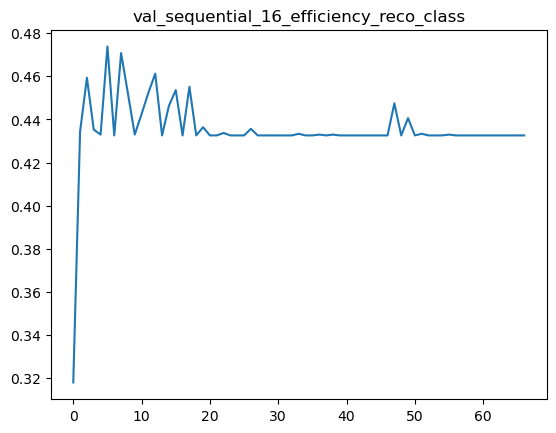

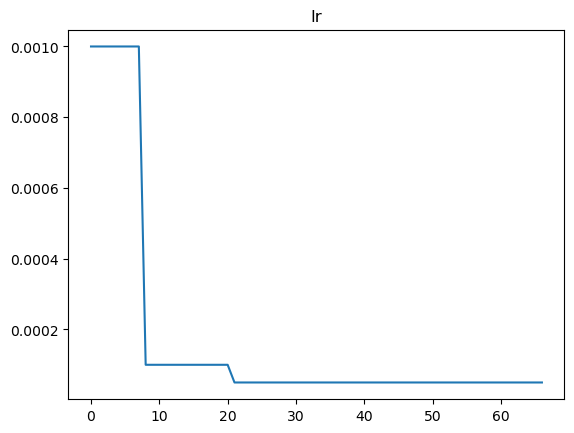

In [8]:
# Makes simple plots of all available metrics.
plt_conf = Plots.PlotConfig()
plt_conf.SHOW_PLOT = True
plt_conf.SAVE_FOLDER = None
# plt_conf.BINS = 30

Models.simple_plot_history(history)

### Loading and evaluating models
As hinted the the Construction section, the models a first created using a model params text file.
The train weights are them imposed onto this.

Here, we load the model before evaluation to confirm it has saved properly (whilst you still have a copy in memory in case it does go wrong!), and then plot some information about performance.

In [ ]:
# List of all current records, excluding the training MC file.
data_path_params = [
    DataPreparation.create_filepath_dictionary("/storage/wx21978/gnn/data_graphs/3GeV_data_Set00_final_07-08-24/"),
    DataPreparation.create_filepath_dictionary("/storage/wx21978/gnn/data_graphs/3GeV_data_Set01_final_07-08-24/"),
    DataPreparation.create_filepath_dictionary("/storage/wx21978/gnn/data_graphs/3GeV_data_Set02_final_07-08-24/"),
    DataPreparation.create_filepath_dictionary("/storage/wx21978/gnn/data_graphs/3GeV_data_Set03_final_07-08-24/")]

mc_path_params = [
    DataPreparation.create_filepath_dictionary("/storage/wx21978/gnn/mc_graphs/3GeV_MC_Set01_final_07-08-24"),
    DataPreparation.create_filepath_dictionary("/storage/wx21978/gnn/mc_graphs/3GeV_MC_Set02_final_07-08-24")]

which_path_params = mc_path_params[0]

In [ ]:
loaded_model = Models.load_model_from_file(model_path, new_data_folder=which_path_params["folder_path"])

In [ ]:
# This chacks the main classification
true_pred, true_truth = Models.evaluate_model(
    loaded_model,
    which_path_params,
    classification_labels=["Abs.", "CEx.", "1 pi", "Multi."],
    plot_config=plt_conf)

In [ ]:
# This looks at the distribution of scores
Models.total_score_dist(
    loaded_model, which_path_params,
    plt_conf, classification_labels=["Abs.", "CEx.", "1 pi", "Multi."])

In [ ]:
# These look at the additional PF classification type losses
Models.plot_binary_extra_loss_dist(
    loaded_model,
    "pion", 3,
    which_path_params, plt_conf)
Models.plot_binary_extra_loss_dist(
    loaded_model,
    "photon", 4,
    which_path_params, plt_conf)
Models.plot_binary_extra_loss_dist(
    loaded_model,
    "true_pi0", 5,#3,
    which_path_params, plt_conf)

In [ ]:
# This looks at how many pi0s/pions the model thinks are included in the event
#   "bt" comapres to preconstructed object counts, "mc" compares to true object counts.
which_true = "bt" # "mc"
Models.plot_regression_extra_loss_dist(
    loaded_model,
    f"{which_true}_pions", 1,
    which_path_params, plt_conf)
Models.plot_regression_extra_loss_dist(
    loaded_model,
    f"{which_true}_pi0s", 2,
    which_path_params, plt_conf)

In [ ]:
# This looks at the reconstructed classification (based on counting reconstructed PFOs not true PFOs)
# Also compares the reconstructed vs. true performance
reco_pred, reco_truth = Models.plot_confusion_extra_loss(
    loaded_model,
    "reco_class", -1,
    which_path_params,
    classification_labels=["Abs.", "CEx.", "1 pi", "Multi."],
    plot_config=plt_conf)
    
Models.plot_confusion_main_vs_reco_loss(
    loaded_model,
    "reco_class", -1,
    which_path_params,
    classification_labels=["Abs.", "CEx.", "1 pi", "Multi."],
    plot_config=plt_conf)

In [ ]:
# Plots a look at the overall score distributions
Models.total_score_dist(
    loaded_model,
    which_path_params,
    plt_conf,
    classification_labels=["Abs.", "CEx.", "1 pi", "Multi."])